## 8월 7일 삼성 DS-KAIST 비학위 프로그램 컴퓨터 비전 중간평가
## Deep Generative Models - GAN
#### TA : Jin Myung Kwak @ MLAI (kwak.jinmyung@kaist.ac.kr)

<img src="cgan_architecture.png" style="width: 250px;" align="left"> 

In this problem, you need to fill in the blanks in order to train and evaluate the conditional GAN model. <br>
GAN generates an image from a noise(z); however, it is not controllable. It randomly generates images. <br>
By concating conditional label(c) with z, GAN will generate images depending on c. <br>

Conditional GAN uses the label as the condition. <br>
In MNIST, corresponding number of the image is the condition. MNIST has 10 conditions that we can use. 

There are two tasks you need to do in this problem: <br>
    - Task1: implement loss for conditonal GAN  <br>
    - Task2: generate images using the conditions 0-9  

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Flatten, multiply
from tensorflow.keras.models import Model
import time
from tqdm import trange

from IPython import display

print(tf.__version__)

os.makedirs('cgan-images',exist_ok=True)

2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Prepare data (MNIST)

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

BUFFER_SIZE = 60000
BATCH_SIZE = 100
z_dim = 100
num_classes = 10
img_shape = (28,28)

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
label_dataset = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

### Generator & Discriminator

In [4]:
class Generator(tf.keras.Model):
    def __init__(self, img_shape, z_dim, num_classes):
        super().__init__()
        self.model = tf.keras.Sequential([
            layers.Dense(256, input_dim=(z_dim+num_classes)),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            layers.Dense(512),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            layers.Dense(1024),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            layers.Dense(np.prod(img_shape), activation='tanh'),
            layers.Reshape(img_shape)
        ])
        self.embed = Embedding(num_classes, num_classes)

    def generate(self, z, c):
        embed_c = self.embed(c)
        z_c = tf.concat([z, embed_c], axis=-1)
        return self.model(z_c)
    

In [5]:
class Discriminator(tf.keras.Model):
    def __init__(self, img_shape, num_classes):
        super().__init__()
        self.model = tf.keras.Sequential([
            layers.Dense(512, input_dim=np.prod(img_shape)+num_classes),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(512),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.4),
            layers.Dense(256),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.4),
            layers.Dense(1)
        ])
        self.embed = Embedding(num_classes, num_classes)

    def discriminate(self, x, c):
        x = Flatten()(x)
        embed_c = self.embed(c)
        x_c = tf.concat([x, embed_c], axis=-1)
        return self.model(x_c)


In [6]:
generator = Generator(img_shape, z_dim, num_classes)
discriminator = Discriminator(img_shape, num_classes)

# Task 1 : Implement Loss Function for Conditional GAN

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def discriminator_loss(real_output, fake_output):
    # (1) Loss for D network: maximize log(D(x,c)) + log(1 - D(G(z,c),c))
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def generator_loss(fake_output):
    # (2) Loss for G network: maximize log(D(G(z,c),c))
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimize Conditional GAN

In [8]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
# hyper parameter  
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 10

# this is for the visualization in training stage
seed_z = tf.random.normal([num_examples_to_generate, noise_dim])
seed_c = np.random.randint(0, 10, size=num_examples_to_generate).reshape((num_examples_to_generate,))

In [10]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator.generate(noise, labels)
        
        real_output = discriminator.discriminate(images, labels)
        fake_output = discriminator.discriminate(generated_images, labels)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def generate_and_save_images(model, epoch, seed_z, seed_c):
    r, c = 2, 5

    gen_imgs = model.generate(seed_z, seed_c)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r,c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].set_title("Digit: %d" %seed_c[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("cgan-images/%d.png" % epoch)
    

In [17]:
def train(dataset, labeldataset, epochs):
    for epoch in trange(epochs):
        for image_batch, label in zip(dataset, labeldataset):
            train_step(image_batch, label)
            
        if epoch % 10 == 0:
            generate_and_save_images(generator,epoch,seed_z, seed_c)
        generator.save_weights(f'cgan_ckpt/gen_{epoch+1}')
        discriminator.save_weights(f'cgan_ckpt/disc_{epoch+1}')
    display.clear_output(wait=True)  
    generate_and_save_images(generator,epochs,seed_z, seed_c)

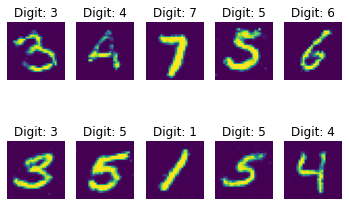

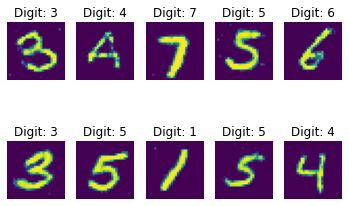

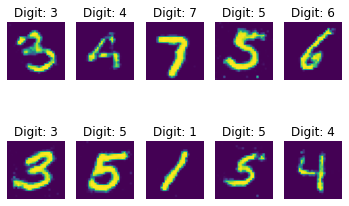

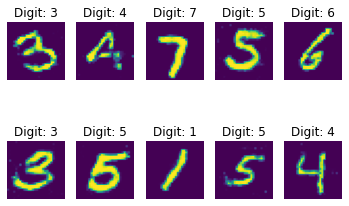

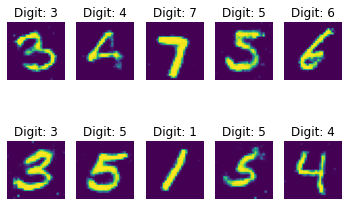

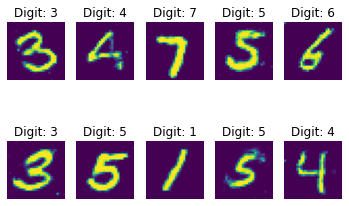

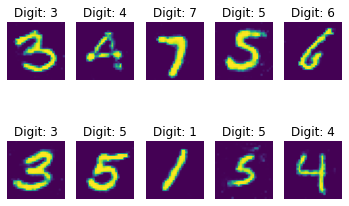

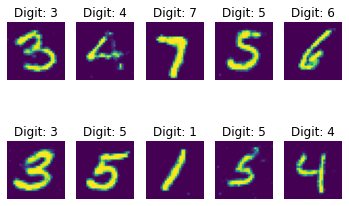

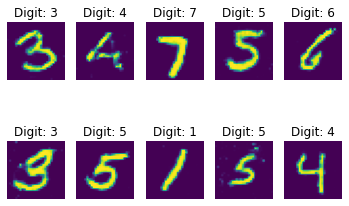

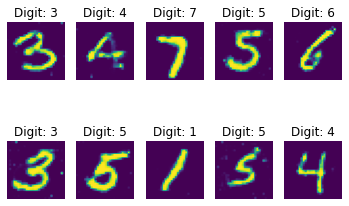

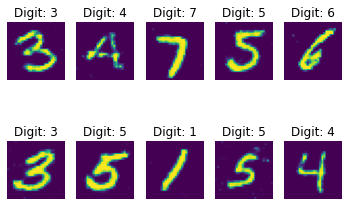

In [18]:
train(train_dataset, label_dataset, EPOCHS)

# Task2 : Visualize Conditional Generation

Plot the images of 0 to 9 that have different font style which can be controlled with z. You can show your result in 10x10 images. 

In [43]:
ckpt_i = 100
generator.load_weights(f'cgan_ckpt/gen_{ckpt_i}')
discriminator.load_weights(f'cgan_ckpt/disc_{ckpt_i}')

In [44]:
# generate points in latent space as input for the generator
def generate_z_points(z_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = np.random.randn(z_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, z_dim)

    return z_input

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    plt.show()



Using above two functions, you can generate the following images. 

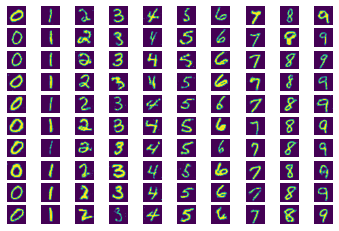

In [45]:
z = generate_z_points(100, 100)
c = np.array([x for _ in range(10) for x in range(10)])
# generate images
gen_images  = generator.generate(z, c)

# plot the result
save_plot(gen_images, 10)